In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import copy
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
tensor_transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=tensor_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


print(f"Train set: {len(train_dataset)} images")
print(f"Test set : {len(test_dataset)} images")


transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset_pretrained = datasets.MNIST(
    root="./data", train=False, transform=transform_pretrained
)
test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=32, shuffle=False)


Train set: 60000 images
Test set : 10000 images


**3.1 Using MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [ ]:
model = MLP()
untrained_model = copy.deepcopy(model)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.4148
Epoch [2/5], Loss: 0.2085
Epoch [3/5], Loss: 0.1669
Epoch [4/5], Loss: 0.1433
Epoch [5/5], Loss: 0.1263


**Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [ ]:
import numpy as np

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (60000, 784) (60000,)
Test : (10000, 784) (10000,)


In [ ]:
lr = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
Accuracy: 0.9266
F1-score: 0.9255


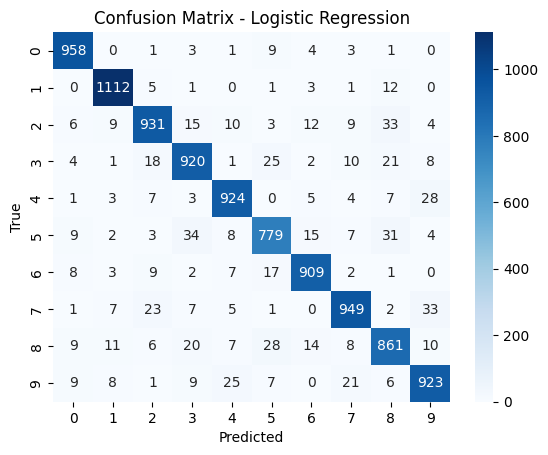


Classification Report:
               precision    recall  f1-score   support

           0     0.9532    0.9776    0.9652       980
           1     0.9619    0.9797    0.9708      1135
           2     0.9273    0.9021    0.9145      1032
           3     0.9073    0.9109    0.9091      1010
           4     0.9352    0.9409    0.9381       982
           5     0.8954    0.8733    0.8842       892
           6     0.9429    0.9489    0.9459       958
           7     0.9359    0.9232    0.9295      1028
           8     0.8831    0.8840    0.8835       974
           9     0.9139    0.9148    0.9143      1009

    accuracy                         0.9266     10000
   macro avg     0.9256    0.9255    0.9255     10000
weighted avg     0.9264    0.9266    0.9264     10000


Random Forest Results:
Accuracy: 0.9704
F1-score: 0.9702


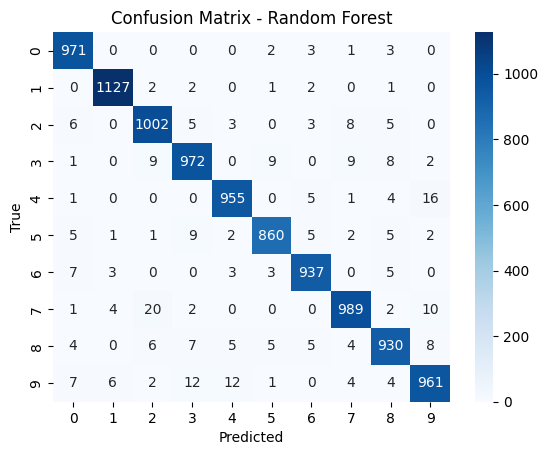


Classification Report:
               precision    recall  f1-score   support

           0     0.9681    0.9908    0.9793       980
           1     0.9877    0.9930    0.9903      1135
           2     0.9616    0.9709    0.9662      1032
           3     0.9633    0.9624    0.9629      1010
           4     0.9745    0.9725    0.9735       982
           5     0.9762    0.9641    0.9701       892
           6     0.9760    0.9781    0.9771       958
           7     0.9715    0.9621    0.9668      1028
           8     0.9617    0.9548    0.9583       974
           9     0.9620    0.9524    0.9572      1009

    accuracy                         0.9704     10000
   macro avg     0.9703    0.9701    0.9702     10000
weighted avg     0.9704    0.9704    0.9704     10000



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


MLP (30→20→10) Results:
Accuracy: 0.9587
F1-score: 0.9582


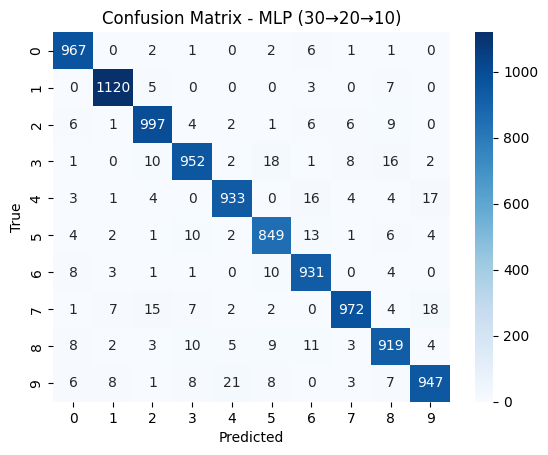


Classification Report:
               precision    recall  f1-score   support

           0     0.9631    0.9867    0.9748       980
           1     0.9790    0.9868    0.9829      1135
           2     0.9596    0.9661    0.9628      1032
           3     0.9587    0.9426    0.9506      1010
           4     0.9648    0.9501    0.9574       982
           5     0.9444    0.9518    0.9481       892
           6     0.9433    0.9718    0.9573       958
           7     0.9739    0.9455    0.9595      1028
           8     0.9406    0.9435    0.9421       974
           9     0.9546    0.9386    0.9465      1009

    accuracy                         0.9587     10000
   macro avg     0.9582    0.9584    0.9582     10000
weighted avg     0.9588    0.9587    0.9587     10000



In [ ]:
y_true = test_dataset.targets.numpy()

model.eval()
y_pred_mlp = []
with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_pred_mlp.extend(preds.cpu().numpy())

y_pred_mlp = np.array(y_pred_mlp)


evaluate_model("MLP (30→20→10)", y_true, y_pred_mlp)

Observations

Random Forest achieved the highest accuracy and F1-score, indicating strong performance on the MNIST dataset without requiring deep learning.

MLP performed slightly below Random Forest but significantly better than Logistic Regression, showing that even a small neural network can learn non-linear digit representations better than a linear model.

Logistic Regression had the lowest accuracy, which is expected because it models only linear relationships, while MNIST digits are complex and often require capturing curved or composite patterns.

Misclassifications

5 - 3, 8

8 - 3, 5, 9

9 - 4, 7

2 - 3 (mostly in Logistic Regression)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

def get_embeddings(model, dataloader):
    model.eval()
    embeddings, labels_list = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            x = images.view(images.size(0), -1)
            # Pass through the first few layers manually (up to 20-neuron layer)
            x = model.layers[0](x)   # Linear(784 → 30)
            x = model.layers[1](x)   # ReLU
            x = model.layers[2](x)   # Linear(30 → 20)
            x = model.layers[3](x)   # ReLU (this gives the 20-neuron activations)
            embeddings.append(x.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels_list)




train_emb_trained, train_labels = get_embeddings(model, test_loader)
train_emb_untrained, _ = get_embeddings(untrained_model, test_loader)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
emb_trained_2d = tsne.fit_transform(train_emb_trained)
emb_untrained_2d = tsne.fit_transform(train_emb_untrained)




/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


**Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.**

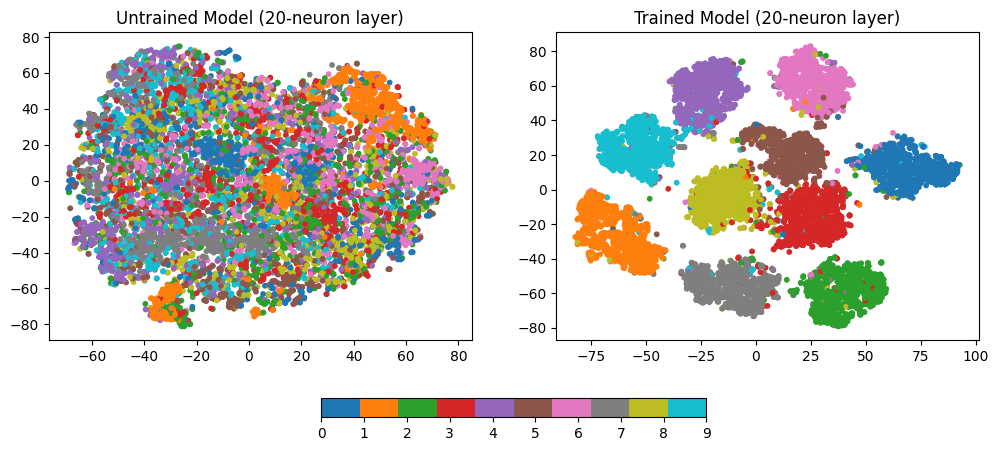

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
scatter1 = axes[0].scatter(emb_untrained_2d[:, 0], emb_untrained_2d[:, 1], c=train_labels, cmap='tab10', s=10)
axes[0].set_title("Untrained Model (20-neuron layer)")

scatter2 = axes[1].scatter(emb_trained_2d[:, 0], emb_trained_2d[:, 1], c=train_labels, cmap='tab10', s=10)
axes[1].set_title("Trained Model (20-neuron layer)")

plt.colorbar(scatter1, ax=axes, orientation='horizontal', fraction=0.05)
plt.show()


Each colour corresponds to one digit(from 0 - 9). As we can see in the untrained model the data points are randomly scattered. After training, digits belonging to the same class are grouped closely together.

**Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.**

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


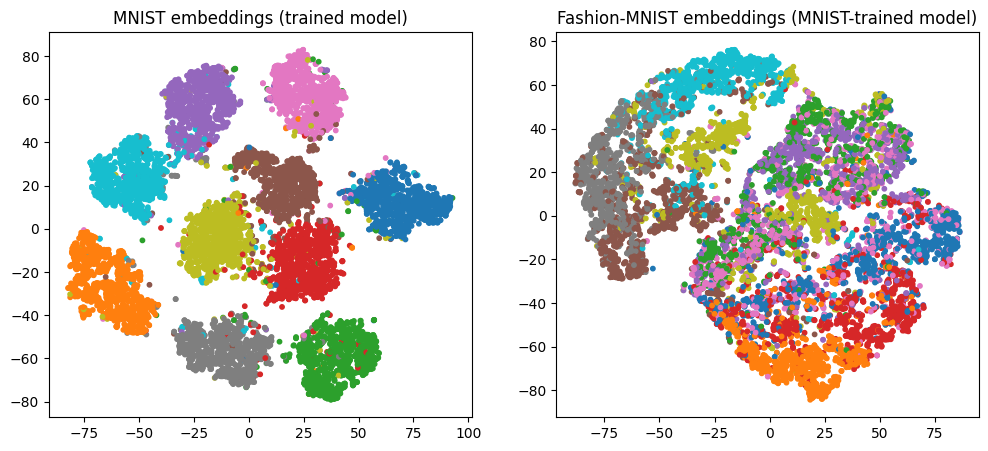

In [ ]:
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True,
                                     transform=transforms.ToTensor())
fashion_loader = torch.utils.data.DataLoader(fashion_test, batch_size=256, shuffle=False)

fashion_emb, fashion_labels = get_embeddings(model, fashion_loader)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
fashion_emb_2d = tsne.fit_transform(fashion_emb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MNIST t-SNE (from before)
axes[0].scatter(emb_trained_2d[:, 0], emb_trained_2d[:, 1], c=train_labels, cmap='tab10', s=10)
axes[0].set_title("MNIST embeddings (trained model)")

# Fashion-MNIST t-SNE
axes[1].scatter(fashion_emb_2d[:, 0], fashion_emb_2d[:, 1], c=fashion_labels, cmap='tab10', s=10)
axes[1].set_title("Fashion-MNIST embeddings (MNIST-trained model)")

plt.show()



Observation:

models trained on one type of data (digits) often fail to perform well on data from a different visual domain (clothing). The model was able to identify strokes, lines, curves etc but may not be able to form meaningful clusters for fashion MNIST because the patterns were not the same like digits.

**3.2 Using CNN**

**Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
simple_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

for epoch in range(3):  # few epochs for demonstration
    simple_cnn.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simple_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2207
Epoch 2, Loss: 0.0673
Epoch 3, Loss: 0.0431


In [ ]:
import time

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    end = time.time()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    inference_time = end - start
    params = sum(p.numel() for p in model.parameters())

    return acc, f1, cm, params, inference_time


**Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.**

In [ ]:
from torchvision import models

# Example pretrained models
alexnet = models.alexnet(weights='IMAGENET1K_V1')
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')

# Modify output layer for 10 MNIST classes
alexnet.classifier[6] = nn.Linear(4096, 10)
mobilenet.classifier[1] = nn.Linear(1280, 10)

alexnet, mobilenet = alexnet.to(device), mobilenet.to(device)

results = {}

for name, model, loader in [
    ("SimpleCNN", simple_cnn, test_loader),
    ("AlexNet", alexnet, test_loader_pretrained),
    ("MobileNetV2", mobilenet, test_loader_pretrained)
]:
    acc, f1, cm, params, t_inf = evaluate_model(model, loader)
    results[name] = {
        "Accuracy": acc,
        "F1": f1,
        "Params": params,
        "InferenceTime": t_inf,
        "ConfMatrix": cm
    }

Compare all three models:
	- Accuracy, F1-score, confusion matrix
	- Model size (number of parameters)
	- Inference time on test set


===== SimpleCNN =====
Accuracy: 98.45%
F1 Score: 0.9844
Parameters: 0.80M
Inference Time: 3.68s


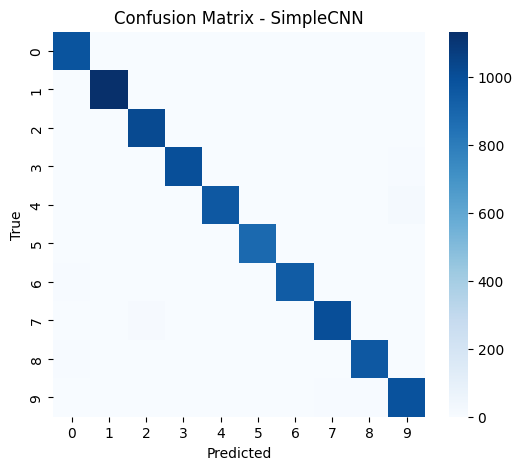


===== AlexNet =====
Accuracy: 7.75%
F1 Score: 0.0349
Parameters: 57.04M
Inference Time: 339.58s


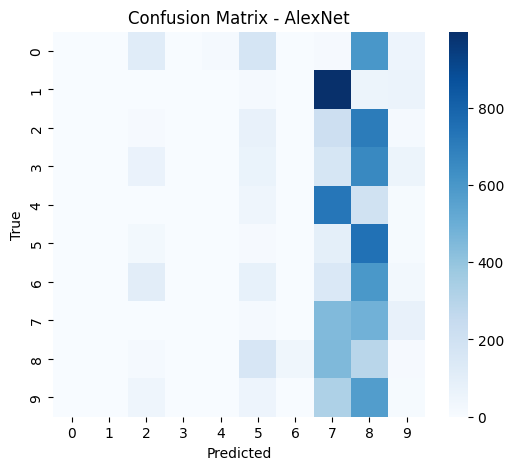


===== MobileNetV2 =====
Accuracy: 9.66%
F1 Score: 0.0413
Parameters: 2.24M
Inference Time: 612.21s


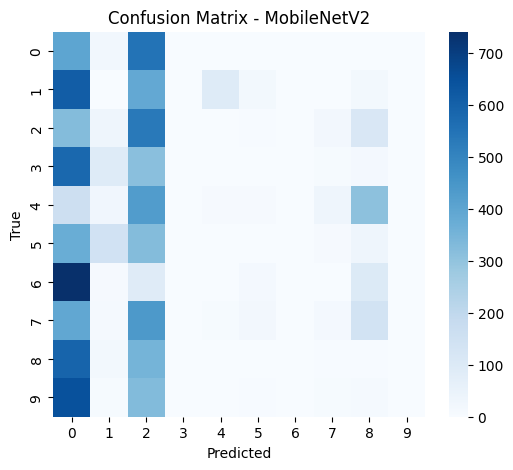

In [ ]:
for name, res in results.items():
    print(f"\n===== {name} =====")
    print(f"Accuracy: {res['Accuracy']*100:.2f}%")
    print(f"F1 Score: {res['F1']:.4f}")
    print(f"Parameters: {res['Params'] / 1e6:.2f}M")
    print(f"Inference Time: {res['InferenceTime']:.2f}s")

    plt.figure(figsize=(6,5))
    sns.heatmap(res['ConfMatrix'], annot=False, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
